In [42]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split
import numpy as np

1.12.0


## Import data

In [136]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}


tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

n_days = 7
n_grid_boxes = tcc.shape[1]*tcc.shape[2]
X = np.empty((n_grid_boxes*n_days*4, 4))
y = np.empty((n_grid_boxes*n_days*4))



for t in range(int(n_days*4)):
    i = 0
    for key, value in my_vars.items():
        if key == 'tcc':
            y[n_grid_boxes*t:n_grid_boxes*(t+1)] = np.array(value[t, : , :]).flatten()
        elif key == 'rh' or key == 'q':
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, 0, : , :]).flatten()
            i = i+1
        else:
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, : , :]).flatten()
            i=i+1

### Standarize and split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)

Xn_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
yn_train = (y_train - y_train.mean())/y_train.std()

Xn_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
yn_test = (y_test - y_train.mean())/y_train.std()

# Data frame

In [138]:
column_names = ['rh', 'q', 'sp', 't2m'] 

In [165]:
yn_train = yn_train.reshape(yn_train.shape[0], 1)
yn_test= yn_test.reshape(yn_test.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
yn_train.shape

(105213, 1)

In [168]:
dfXn_train=pd.DataFrame(Xn_train, columns=column_names) 
dfX_train=pd.DataFrame(X_train, columns=column_names) 
dfXn_train.head()

,rh,q,sp,t2m
0,1.393791,-0.714007,-0.005445,-1.018044
1,0.417109,-0.668152,0.819933,-0.531818
2,1.181194,0.910089,-0.806767,0.404965
3,0.434837,-0.209390,-1.107624,-0.360857
4,-0.454854,1.922001,0.683297,1.726723


In [141]:
dfXn_test=pd.DataFrame(Xn_test, columns=column_names) 
dfXn_test.head()

,rh,q,sp,t2m
0,1.196036,-1.690350,0.525812,-2.822024
1,1.134195,-1.476397,0.503681,-1.879484
2,1.029064,-1.410936,0.500046,-1.719161
3,0.786234,-1.202125,0.486254,-1.272233
4,0.629569,-0.979600,0.459418,-0.952713


In [169]:
dfyn_train = pd.DataFrame(yn_train , columns=['tcc']) 
dfy_train = pd.DataFrame(y_train , columns=['tcc']) 
dfyn_train.head()

,tcc
0,0.905219
1,0.909331
2,0.470537
3,-1.711220
4,-1.255178


In [143]:
dfyn_test = pd.DataFrame(yn_test , columns=['tcc']) 
dfyn_test.head()

,tcc
0,0.909331
1,0.909331
2,0.909331
3,0.904044
4,0.884487


In [144]:
df_train = pd.merge(dfyn_train, dfXn_train, left_index=True,right_index=True)
df_train.head()

,tcc,rh,q,sp,t2m
0,0.905219,1.393791,-0.714007,-0.005445,-1.018044
1,0.909331,0.417109,-0.668152,0.819933,-0.531818
2,0.470537,1.181194,0.910089,-0.806767,0.404965
3,-1.711220,0.434837,-0.209390,-1.107624,-0.360857
4,-1.255178,-0.454854,1.922001,0.683297,1.726723


In [145]:
df_test = pd.merge(dfyn_test, dfXn_test, left_index=True,right_index=True)
df_test.head()

,tcc,rh,q,sp,t2m
0,0.909331,1.196036,-1.690350,0.525812,-2.822024
1,0.909331,1.134195,-1.476397,0.503681,-1.879484
2,0.909331,1.029064,-1.410936,0.500046,-1.719161
3,0.904044,0.786234,-1.202125,0.486254,-1.272233
4,0.884487,0.629569,-0.979600,0.459418,-0.952713


In [170]:
df_t = pd.merge(dfy_train, dfX_train, left_index=True,right_index=True)
df_t.head()

,tcc,rh,q,sp,t2m
0,0.998505,98.606569,0.002789,98941.036848,269.768001
1,1.000000,84.184912,0.002881,101904.900207,273.408567
2,0.840447,95.467368,0.006023,96063.555517,280.422633
3,0.047121,84.446682,0.003794,94983.204287,274.688623
4,0.212946,71.309520,0.008037,101414.250288,290.319165


## clean data

In [146]:
df_train.isna().sum()

tcc    0
rh     0
q      0
sp     0
t2m    0
dtype: int64

In [147]:
# There is none nan in the data
# df_train = df_train.dropna()

In [148]:
df_test.isna().sum()

tcc    0
rh     0
q      0
sp     0
t2m    0
dtype: int64

In [149]:
# There is none nan in the data
# df_test = df_test.dropna()

## Inspect the data

C:\Users\nbpst2\Anaconda3\envs\tflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


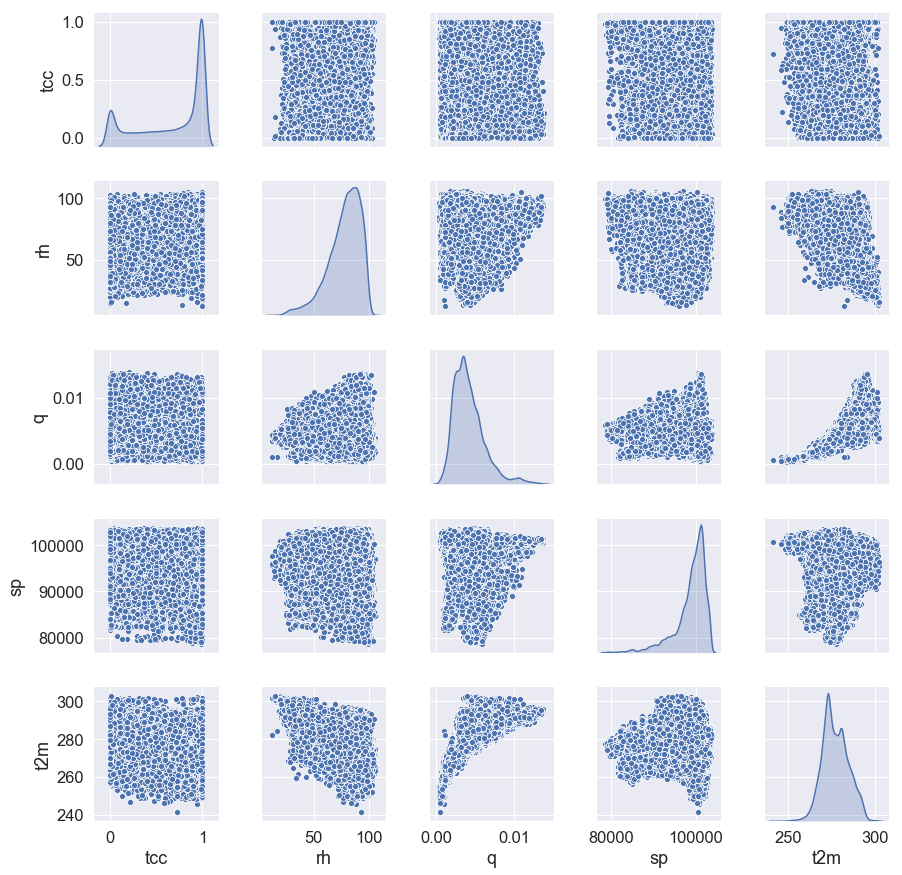

In [172]:
sns.set(font_scale=1.5)
sns.pairplot(df_t, diag_kind="kde")
#plt.savefig('results/inspection.png')

## Also look at the overall statistics:

In [195]:
train_stats = df_t.describe()
train_stats

,tcc,rh,q,sp,t2m
count,1.052130e+05,105213.000000,105213.000000,105213.000000,105213.000000
mean,6.693511e-01,78.025889,0.004211,98960.589735,277.390501
std,3.636194e-01,14.766043,0.001991,3590.932977,7.487433
min,9.998669e-13,11.883853,0.000306,78702.687500,241.299423
25%,3.597729e-01,69.945885,0.002794,97688.305483,272.173492
50%,8.407520e-01,80.645955,0.003846,99918.497484,276.731463
75%,9.968565e-01,89.158527,0.005206,101376.626116,282.527321
max,1.000000e+00,106.343980,0.013828,103829.875710,302.709274


# Build the model

In [175]:
# Define the R-squared metric
from keras import backend as K
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Varying the optimizer using relu as activation

### RMSPropOptimizer

In [152]:
train_labels = df_train.pop('tcc')
test_labels = df_test.pop('tcc')

In [153]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [154]:
model = build_model()

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


#### Now try out the model. Take a batch of 10 exampes from the training data and call model.predict on it.

In [156]:
example_batch = df_train[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.22365291],
       [-0.18896629],
       [-0.3573517 ],
       [-0.27927354],
       [-0.41499433],
       [-0.14781132],
       [-0.46418548],
       [-0.08520873],
       [-0.11493862],
       [-0.36297125]], dtype=float32)

#### Train the model
The model is trained for 1000 epochs, and record the training and validation accuracy in the history object

In [157]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  df_train, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Save the model

In [158]:
# Save entire model to a HDF5 file
model.save('keras_RMSPOpt0001_1000e_relu.h5')

#### Visualize the model's training progress using the stats stored in the history object.

In [159]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,0.572527,0.579692,0.572527,0.539500,0.559442,0.539500,995
996,0.560521,0.558226,0.560521,0.540386,0.559505,0.540386,996
997,0.573881,0.566241,0.573881,0.540403,0.559237,0.540403,997
998,0.564932,0.571053,0.564932,0.539898,0.560040,0.539898,998
999,0.559301,0.575718,0.559301,0.540988,0.559492,0.540988,999


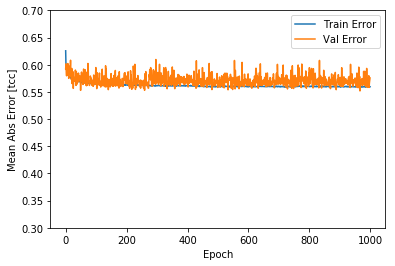

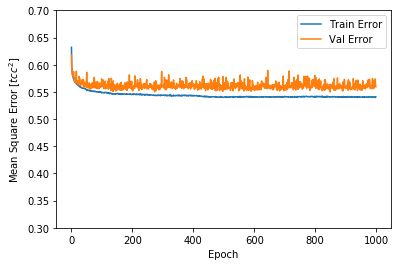

In [160]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [tcc]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0.3, 0.7])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$tcc^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0.3, 0.7])

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
..................................................................

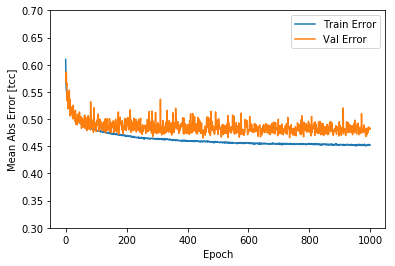

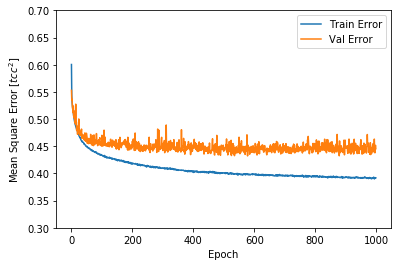

In [114]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

#### Let's see how did the model performs on the test set

In [116]:
loss, mae, mse = model.evaluate(df_test, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} tcc".format(mae))

Testing set Mean Abs Error:  0.48 tcc


#### Make predictions

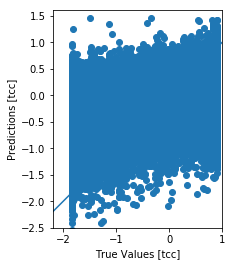

In [161]:
test_predictions = model.predict(df_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tcc]')
plt.ylabel('Predictions [tcc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2.2, 1])
plt.ylim([-2.5,1.6])
_ = plt.plot([-100, 100], [-100, 100])

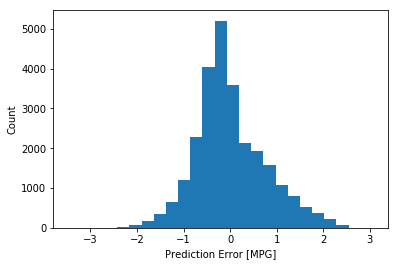

In [162]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [163]:
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.43525837903366804

##### 32 nodes


....................................................................................................
....................................................................................................
...................

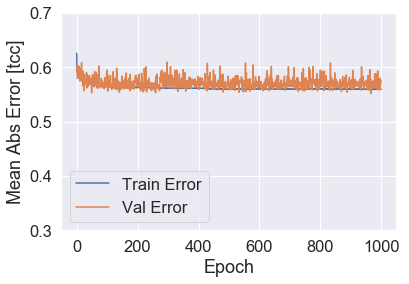

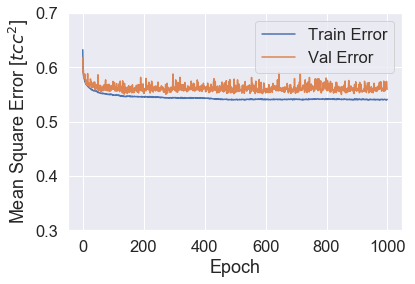

In [213]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

### Adam

In [196]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse', r_squared])
  return model


....................................................................................................
....................................................................................................
................

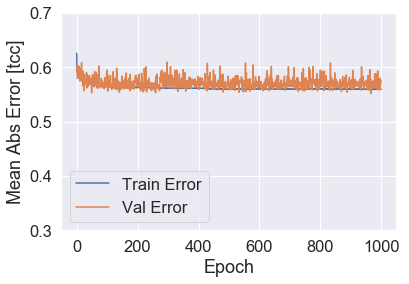

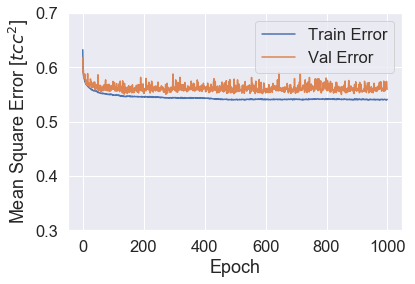

In [199]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

  
plot_history(history)

In [212]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4492509591709768

### SGD

In [193]:
from keras import optimizers
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  sgd = keras.optimizers.SGD(lr=0.01, nesterov=True)

  model.compile(loss='mse',
                optimizer=sgd,
                metrics=['mae', 'mse', r_squared])
  return model


....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

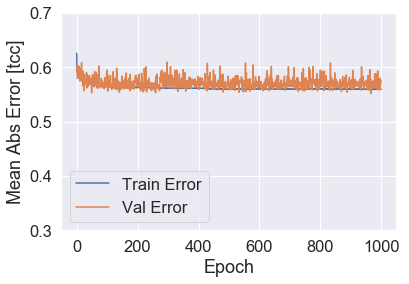

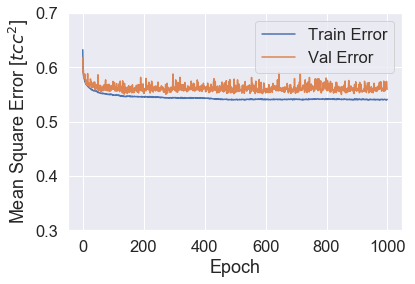

In [194]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Varying activation function using RMSPropOptimizer